In [1]:
import shutup
shutup.please()
import pandas as pd
import numpy as np
from jax import random, numpy as jnp
from numpyro import distributions as dist
import numpyro
import arviz
from matplotlib import pyplot as plt
import plotly.express as px
import cufflinks as cf
cf.go_offline()
from arm_numpyro_utilities import inference_utils, transformations

# Loading the Data
First, we load the data from the book's website. I'm not quite sure why, but the data from the website doesn't contain the exact same fields - we only whether or not a parent is a smoker, instead of the number of parents that are smokers. This shouldn't materially change the model for our purposes.

In [2]:
data = (
    pd.read_table(
        "http://www.stat.columbia.edu/~gelman/arm/examples/smoking/smoke_pub.dat",
        sep='\t',
    )
)

As in the book, we plot the trend of the smoking rate at each data collection wave, segmented by gender.

In [3]:
px.line(
    data
    .groupby(['sex(1=F)', 'wave'])
    ['smkreg']
    .mean()
    .reset_index(), 
    x='wave', 
    y='smkreg', 
    color='sex(1=F)',
    labels={
        'smkreg': "Proportion of Respondents that Smoke Regularly",
        'sex(1=F)': "Is Female",
        'wave': "Response Wave"
    },
    title="Regular smoking rate increased with time faster for female respondents"
)

This informs the model below, as we include a different time trend for female and male respondents ($\beta_3$ and $\beta_4$).

# Implementing the Model
This is a pretty simple model. We have a few coefficients, and a person-level intercept. As in Equation 11.3:
$$
Pr(y_{jt}) = \textrm{logit}^{-1} (\beta_0 +\beta_1 \textrm{psmoke_j} + \beta_2 \textrm{female}_j + 
\beta_3 (1 - \textrm{female}_j) t + \beta_4 \textrm{female}_j)
$$

In [4]:
def repeated_measurements_model(female, psmoke, wave, is_smoker):
    beta_0 = numpyro.sample('beta_0', dist.Normal(0, .5))
    beta_1 = numpyro.sample('beta_1_psmoke', dist.Normal(0, .5))
    beta_2 = numpyro.sample('beta_2_female', dist.Normal(0, .5))
    beta_3 = numpyro.sample('beta_3_male_t_int', dist.Normal(0, .5))
    beta_4 = numpyro.sample('beta_4_female_t_int', dist.Normal(0, .5))
    standard_error = numpyro.sample('standard_error', dist.HalfNormal(.5))
    
    unnormalized_mean = numpyro.deterministic(
        'unnormalized_mean',
        (
            beta_0 + 
            beta_1 * psmoke + 
            beta_2 * female + 
            beta_3 * (1 - female) * wave + 
            beta_4 * female * wave
        )
    )

    with numpyro.plate('data', len(is_smoker)):
        y = numpyro.sample(
            'y',
            dist.Normal(
                transformations.logistic(unnormalized_mean),
                standard_error
            ),
            obs=is_smoker
        )

# MCMC
Next, we use the NUTS sampler with the MCMC utilities from NumPyro to create posterior samples from the model.

In [5]:
mcmc = inference_utils.get_nuts_mcmc(
    model=repeated_measurements_model,
    num_samples=1000, 
    num_warmup=1000, 
    model_kwargs=dict(
        female=jnp.array(data['sex(1=F)'].values),
        psmoke=jnp.array(data['parsmk'].values),
        wave=jnp.array(data['wave'].values),
        is_smoker=jnp.array(data['smkreg'].values)
    )
)

sample: 100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 118.07it/s, 15 steps of size 1.76e-01. acc. prob=0.92]


We print a quick summary, to ensure that the sampling has mixed appropriately ($\hat{r}$ close to 1).

In [6]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
               beta_0     -2.80      0.14     -2.80     -2.99     -2.56    317.69      1.00
        beta_1_psmoke      0.92      0.06      0.92      0.81      1.02    574.06      1.00
        beta_2_female     -0.04      0.17     -0.05     -0.32      0.23    369.97      1.00
    beta_3_male_t_int      0.07      0.03      0.07      0.02      0.12    365.55      1.00
  beta_4_female_t_int      0.17      0.03      0.17      0.13      0.21    577.37      1.00
       standard_error      0.32      0.00      0.32      0.32      0.33    947.93      1.00

Number of divergences: 0


# Plotting Results
For plotting results, the `arviz` package has some nice tooling. It's not too customizable, so I usually end up using Plotly or Matplotlib, but it has some common, easy-to-use, out of the box charts.

Below, the forest-plot for the $\beta$s are shown. For each variable, the 90% posterior interval is shown as a line, with the thicker part of the line indicating the posterior IQR. 

array([<AxesSubplot:title={'center':'90.0% HDI'}>], dtype=object)

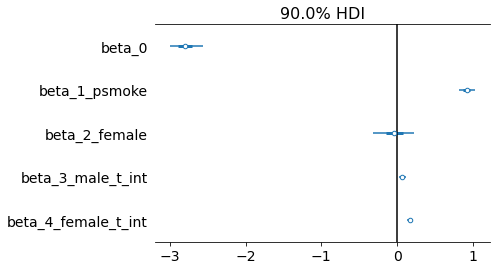

In [7]:
az = arviz.from_numpyro(posterior=mcmc)

ax, fig = plt.subplots()
fig.axvline(x=0, color='black',)
arviz.plot_forest(
    az, 
    filter_vars='like', 
    var_names=['beta'],
    ax=fig, hdi_prob=.9
)

There are a few takeaways from the posterior:
1. $\beta_0$ is around -3.5, indicating about a 6% smoking rate before adjusting for covariates.
1. A respondent with a parent who smokes are more likely to smoke, moving the base rate to about 13% for that population.
2. There is indeed a slight "time trend" for female respondents, indicating a higher change of a respondant taking up smoking in later waves. Note that this value gets multiplied by up to 6 to accounts for the waves, so by the 6th wave, this is a difference of about 6% at the population mean. 

Note that the original model includes a personal parameter $\alpha_j$, which I've removed. The personal variance is captured by the standard error in the regression model above, and so provides a redundancy.

# Posterior Simulation
Next, we can use the posterior samples to understand the model. This is especially helpful because the logistic part of the model can be difficult to interpret. 

We start by defining 8 observations - "M/F" X "Parent Smokes or Not" X "Wave=1 or Wave=6]. The `y` values are set to null as clarification that the observed values are not used at this point.

In [8]:
# Get the samples using the Predictive utility.
posterior_samples = numpyro.infer.Predictive(
    model=repeated_measurements_model,
    posterior_samples=mcmc.get_samples()
)(
    female=jnp.tile(jnp.array([1, 0, 1, 0]), 2),
    psmoke=jnp.tile(jnp.array([1, 1, 0, 0]), 2),
    wave=jnp.array([1, 1, 1, 1, 6, 6, 6, 6]),
    is_smoker=jnp.array([jnp.nan] * 8), 
    rng_key=random.PRNGKey(0)
)

avg_response_rates = (
    pd.DataFrame(
        transformations.logistic(posterior_samples['unnormalized_mean']),
        columns=(
            ['F, Smokes, 1', 'M, Smokes, 1', 'F, Doesn\'t Smoke, 1', 'M, Doesn\'t Smoke, 1'] + 
            ['F, Smokes, 6', 'M, Smokes, 6', 'F, Doesn\'t Smoke, 6', 'M, Doesn\'t Smoke, 6']
        )
    )
    .melt()
    .assign(is_female=lambda df: df['variable'].map(lambda x: x.split(',')[0]))
    .assign(wave=lambda df: df['variable'].map(lambda x: x.split(',')[-1]))
    .assign(parent=lambda df: df['variable'].map(lambda x: x.split(',')[-2]))


)

px.box(
    avg_response_rates,
    x='is_female', 
    y='value',
    color='wave',
    facet_col='parent',
    labels={
        'value': "Posterior Regular Smoker Proportion", 
        'parent': "Parent",
        'is_female': "Sex",
        'wave': "Wave"
    },
    title="Respondents are more likely to smoke regularly as time goes on, and if they have a parent who smokes"
)